IMPORT LIBRARIES

In [207]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, log_loss
)


2. LOAD DATA + SIZE CONTROL

In [208]:
# df = pd.read_csv("loan_data.csv", low_memory=False)
df = pd.read_csv("../data/accepted_2007_to_2018Q4.csv", low_memory=False)
df = df.sample(150000, random_state=42)


3. DEFINE TARGET VARIABLES

3A️ Inspect loan status

In [209]:
df['loan_status'].value_counts()


loan_status
Fully Paid                                             71242
Current                                                58315
Charged Off                                            17950
Late (31-120 days)                                      1491
In Grace Period                                          558
Late (16-30 days)                                        285
Does not meet the credit policy. Status:Fully Paid       105
Does not meet the credit policy. Status:Charged Off       48
Default                                                    2
Name: count, dtype: int64

3B️ Binary classification logic

In [210]:
bad_loans = [
    'Charged Off',
    'Default',
    'Late (31-120 days)'
]

good_loans = ['Fully Paid']

df = df[df['loan_status'].isin(bad_loans + good_loans)]

df['loan_status'] = df['loan_status'].apply(
    lambda x: 1 if x in bad_loans else 0
)


3C️ VERIFY (MANDATORY)

In [211]:
df['loan_status'].value_counts()


loan_status
0    71242
1    19443
Name: count, dtype: int64

4. SELECT RELEVANT FEATURES

In [212]:
# df = df[selected_cols]


5. EXPLORATORY DATA ANALYSIS

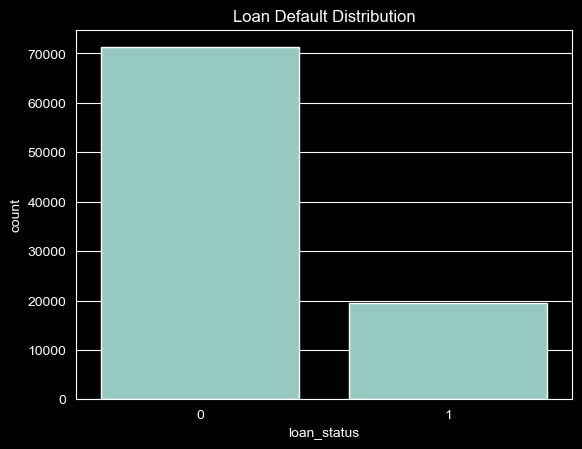

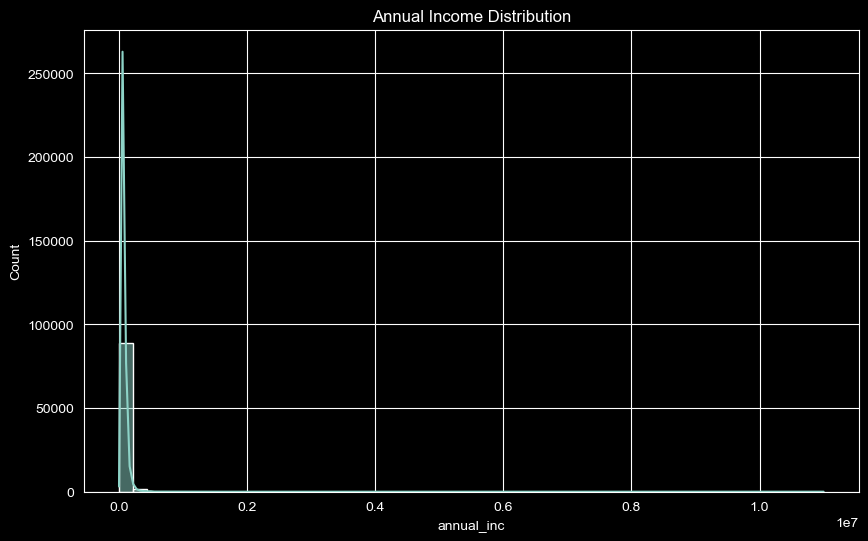

In [213]:
sns.countplot(x=df['loan_status'])
plt.title("Loan Default Distribution")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df['annual_inc'], bins=50, kde=True)
plt.title("Annual Income Distribution")
plt.show()


6. HANDLE MISSING VALUES

In [214]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("loan_status")
cat_cols = df.select_dtypes(include=["object"]).columns

In [215]:
high_card_cols = [c for c in cat_cols if df[c].nunique() > 10]
df.drop(columns=high_card_cols, inplace=True)

In [216]:
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

In [217]:
#df.columns

In [218]:
all_null_cols = [c for c in num_cols if df[c].isna().all()]
df.drop(columns=all_null_cols, inplace=True)
valid_cols = [c for c in num_cols if c not in all_null_cols]

In [219]:
df[valid_cols] = num_imputer.fit_transform(df[valid_cols])

cat_cols = df.select_dtypes(include="object").columns
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

7. FEATURE ENGINEERING

In [220]:
df["term"] = df["term"].str.replace(" months", "", regex=False).astype(int)

# Encode categoricals
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


8. OUTLIER HANDLING (IQR METHOD)

In [221]:
# Q1 = df[num_cols].quantile(0.25)
# Q3 = df[num_cols].quantile(0.75)
# IQR = Q3 - Q1
#
# df = df[~((df[num_cols] < (Q1 - 1.5 * IQR)) |
#           (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

#num_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("loan_status")

for col in valid_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = df[col].clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)


9. FEATURE / TARGET SPLIT + SCALING

In [222]:
X = df.drop("loan_status", axis=1)
y = df["loan_status"]


In [223]:
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

In [224]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

    10. TRAIN–TEST SPLIT

In [225]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [226]:
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72548, 149)

(18137, 149)

(72548,)

(18137,)

In [227]:
y_train.head(5)

669189     1
1857497    0
283298     0
187669     0
349875     0
Name: loan_status, dtype: int64

In [228]:
if y_train.nunique() < 2:
    raise ValueError("Training data has only one class!")

11. PCA


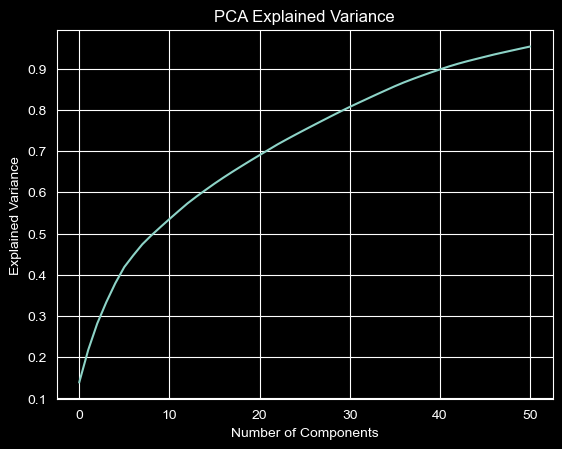

In [229]:
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("PCA Explained Variance")
plt.show()


QUICK TEST

In [230]:
print("Full dataset:")
print(df['loan_status'].value_counts())

print("\nTraining labels:")
print(y_train.value_counts())

print("\nTest labels:")
print(y_test.value_counts())


Full dataset:
loan_status
0    71242
1    19443
Name: count, dtype: int64

Training labels:
loan_status
0    56994
1    15554
Name: count, dtype: int64

Test labels:
loan_status
0    14248
1     3889
Name: count, dtype: int64


12. MODEL TRAINING

In [231]:
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)
svm = SVC(probability=True)
nb = GaussianNB()

lr.fit(X_train_pca, y_train)
rf.fit(X_train_pca, y_train)
svm.fit(X_train_pca, y_train)
nb.fit(X_train_pca, y_train)


,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


13. HYPERPARAMETER TUNING (Random Forest)

In [233]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1'
)

grid.fit(X_train_pca, y_train)
best_rf = grid.best_estimator_


14. MODEL EVALUATION

In [234]:
models = {
    "Logistic Regression": lr,
    "Random Forest": best_rf,
    "SVM": svm,
    "Naive Bayes": nb
}

for name, model in models.items():
    y_pred = model.predict(X_test_pca)
    y_prob = model.predict_proba(X_test_pca)[:,1]

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("Log Loss:", log_loss(y_test, y_prob))
    print(confusion_matrix(y_test, y_pred))



Logistic Regression
Accuracy: 0.9885317307162155
Precision: 0.9844695972624374
Recall: 0.9616868089483157
F1: 0.9729448491155047
ROC-AUC: 0.9983843126259601
Log Loss: 0.04253260395269095
[[14189    59]
 [  149  3740]]

Random Forest
Accuracy: 0.9443678667916414
Precision: 0.915944540727903
Recall: 0.8153767035227565
F1: 0.8627397632975106
ROC-AUC: 0.9790916236916372
Log Loss: 0.16579145381708205
[[13957   291]
 [  718  3171]]

SVM
Accuracy: 0.978772674642995
Precision: 0.9574412532637075
Recall: 0.9429159166880946
F1: 0.9501230729369089
ROC-AUC: 0.99668289236013
Log Loss: 0.05812382419111318
[[14085   163]
 [  222  3667]]

Naive Bayes
Accuracy: 0.8091194795170095
Precision: 0.7035271687321258
Recall: 0.18976600668552326
F1: 0.29890643985419196
ROC-AUC: 0.862192457050357
Log Loss: 3.2190215843888335
[[13937   311]
 [ 3151   738]]


🔹 15. MODEL DEPLOYMENT (UNSEEN DATA)

In [235]:
new_customer = np.array([[15000, 36, 13.5, 500, 2, 5, 4, 45000, 18, 720]])
new_customer_scaled = scaler.transform(new_customer)
new_customer_pca = pca.transform(new_customer_scaled)

prediction = best_rf.predict(new_customer_pca)

print("Loan Default Prediction (1=Default, 0=No Default):", prediction)


C:\Users\oluwa\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 10 features, but StandardScaler is expecting 149 features as input.